In [1]:
from firedrake import *
import torch
import matplotlib.pyplot as plt
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)


firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [15]:
ncells = 100
L = 10.
mesh = PeriodicIntervalMesh(ncells, L)

V = FunctionSpace(mesh, "HER", 3)

un = Function(V)
unp1 = Function(V)

uh = (un + unp1)/2

v = TestFunction(V)

dt = 0.01
dT = Constant(dt)

# alpha = Constant(1.0)
# beta = Constant(0.02923)
# gamma = Constant(1.)

nu = Constant(0.029)

eqn = (
    v*(unp1 - un)
    - dT*v.dx(0)*uh.dx(0)
    + dT*nu*v.dx(0).dx(0)*uh.dx(0).dx(0)
    - dT*0.5*v.dx(0)*uh*uh
    )*dx

params = {
    "snes_atol": 1.0e-50,
    "snes_rtol": 1.0e-6,
    "snes_stol": 1.0e-50,
    "ksp_type":"preonly",
    "pc_type":"lu"
}

#make the solver
KSProb = NonlinearVariationalProblem(eqn, unp1)
KSSolver = NonlinearVariationalSolver(KSProb,
                                      solver_parameters=params)

#initial condition

x, = SpatialCoordinate(mesh)
un.project(-sin(pi*2*x/L))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fdcf4c62fe0>, FiniteElement('Hermite', interval, 3), name=None), Mesh(VectorElement(FiniteElement('Discontinuous Lagrange', interval, 1, variant='equispaced'), dim=1, variant='equispaced'), 405)), 443)

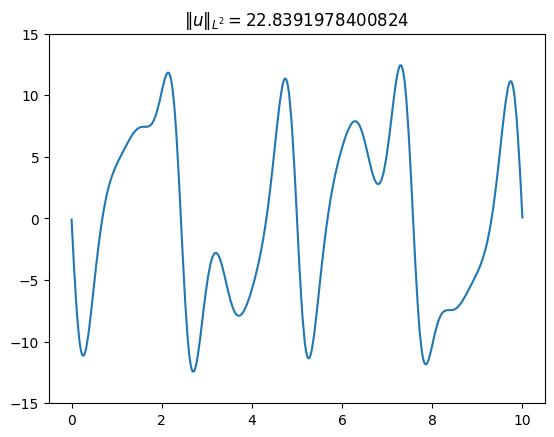

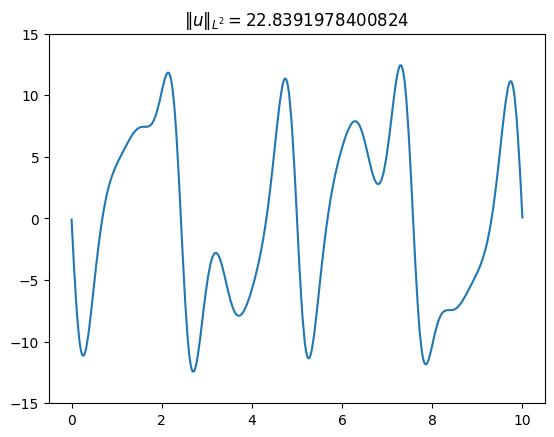

In [16]:
import time
from IPython import display

t=0.
tmax = 10.
tdump = 1.
dumpt = 0.

# file0 = File("stuff.pvd")
VOut = FunctionSpace(mesh, "CG", 3)
uout = Function(VOut)
uout.interpolate(un)
# file0.write(uout)

fig, axes = plt.subplots()
hdisplay = display.display("", display_id=True)

observable = []
t_range = []
integrals = []
while t < tmax - dt/2:
    axes.cla()
    axes.set_ylim([-15, 15])

    t += dt

    KSSolver.solve()
    un.assign(unp1)


    uout.interpolate(un)
    
    curr_norm = norm(un)
    curr_int = assemble(un * dx)
    integrals.append(curr_int)
    observable.append(curr_norm)
    t_range.append(t)
    
    axes.set_title("$\Vert u \Vert_{L^2} = " + f"{curr_norm}$")

    plot(uout, axes=axes)
    hdisplay.update(fig)
    

In [21]:
observable = np.array(observable)
dEdt = np.gradient(observable, dt)

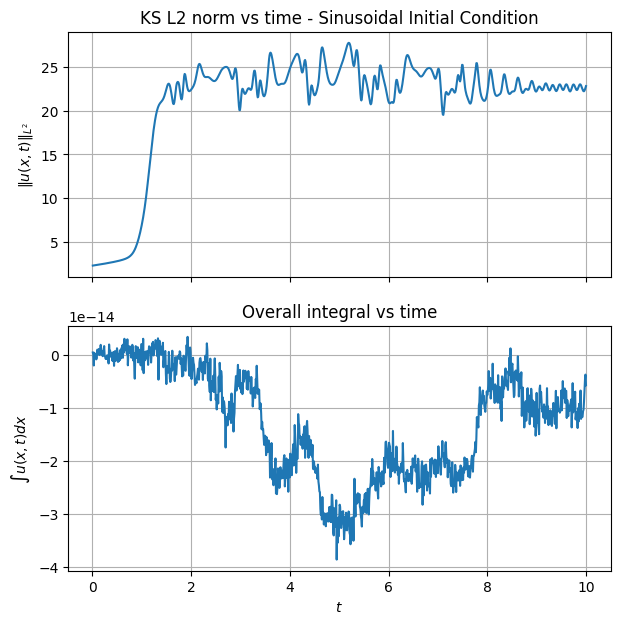

In [43]:
fig, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

axes[0].plot(t_range, observable)
axes[0].set_title("KS L2 norm vs time - Sinusoidal Initial Condition")
axes[0].set_ylabel("$\Vert u(x, t) \Vert_{L^2}$")
axes[0].grid()

axes[1].plot(t_range, integrals)
axes[1].set_title("Overall integral vs time")
axes[1].set_xlabel("$t$")
axes[1].set_ylabel("$\int u(x, t) dx$")
axes[1].grid()


plt.savefig("KS L2 norm and error plot")

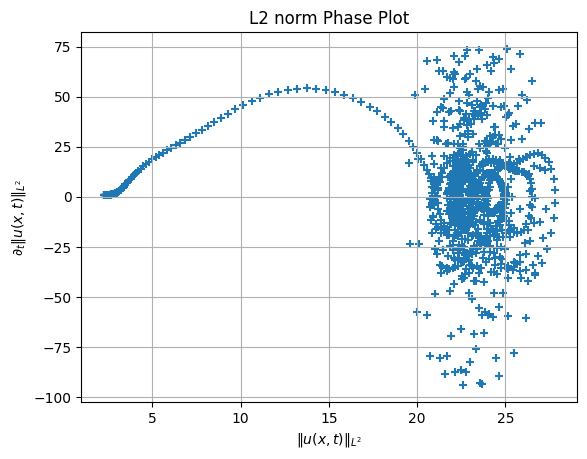

In [45]:
plt.scatter(observable, dEdt, marker="+")
plt.title("L2 norm Phase Plot")
plt.ylabel("$\partial_t \Vert u(x, t) \Vert_{L^2}$")
plt.xlabel("$\Vert u(x, t) \Vert_{L^2}$")
plt.grid()

plt.savefig("KS L2 phase plot")

Text(0, 0.5, '$\\int u(x, t) dx$')

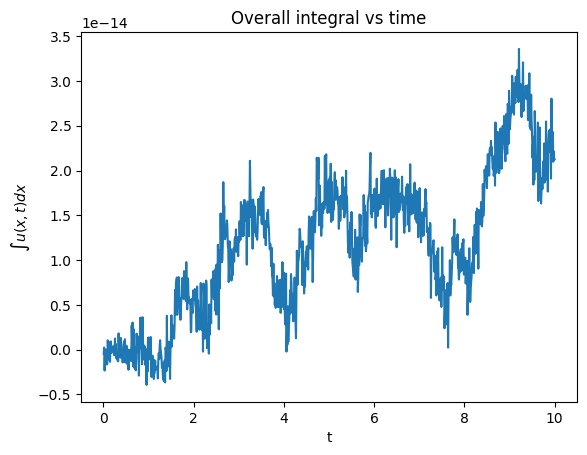

In [8]:
# The error is close to zero


In [7]:

N = 4096
L = 10.
T = 0.5
nu = 0.029
dt = 0.01
samples = 600

with CheckpointFile(f"/home/clustor2/ma/n/np923/fem_neural_operator/fem_neural_operator/data/KS/meshes/N{N}.h5", "r") as f:
    mesh = f.load_mesh()
    
fs = FunctionSpace(mesh, "HER", 3) 
fs_out = FunctionSpace(mesh, "CG", 3)


# data = torch.load(f"/home/clustor2/ma/n/np923/fem_neural_operator/fem_neural_operator/data/KS/samples/N{N}_nu{nu}_T{T}_samples{samples}_batch1.pt")

Text(0.5, 1.0, 'Datapoint 55')

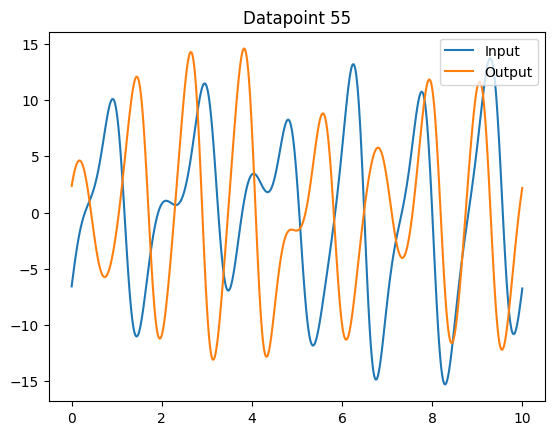

In [7]:
index = 55

func_in_her = Function(fs, val=data[index, 0, :].numpy())
func_out_her = Function(fs, val=data[index, 1, :].numpy())

func_in = Function(fs_out)
func_out = Function(fs_out)

func_in.interpolate(func_in_her)
func_out.interpolate(func_out_her)

fig, axes = plt.subplots()

plot(func_in, axes=axes, label="Input")
plot(func_out, axes=axes, label="Output")
axes.legend()
axes.set_title(f"Datapoint {index}")

In [9]:
from classes import Dataset
from torch.utils.data.dataloader import DataLoader

device = torch.device("cuda")
N = 4096

samples = torch.load(f"../../data/KS/samples/N{N}_HER_nu0029_T01_samples1200.pt").unsqueeze(2).to(device=device, dtype=torch.float64)
print(samples.shape)
grid = torch.linspace(0, 1, 2 * N, device=device)
dataset = Dataset(samples, grid)
print(dataset.inputs.shape, dataset.targets.shape)

trainset = dataset[:1000]  # Cutting off the train data
testset = dataset[1000:]

loader = DataLoader(trainset, 32)

torch.Size([1200, 2, 1, 8192])
torch.Size([1200, 2, 8192]) torch.Size([1200, 1, 8192])


In [10]:
for x, y in loader:
    print(x.shape, y.shape)

RuntimeError: stack expects each tensor to be equal size, but got [1000, 2, 8192] at entry 0 and [1000, 1, 8192] at entry 1

In [2]:
samples = (torch.load(f"playground/data/burgers/samples/N8192_nu0.01_samples40_batch1.pt")
            .unsqueeze(2).to(device=device, dtype=torch.float64))
grid = torch.linspace(0, 1, 8192, device=device)
dataset = BurgersDataset(samples, grid)
burger_loader = DataLoader(dataset, 32)


FileNotFoundError: [Errno 2] No such file or directory: 'playground/data/burgers/samples/N8192_nu0.01_samples40_batch1.pt'

In [42]:
for x, y in burger_loader:
    print(x.shape, y.shape)

torch.Size([32, 2, 8192]) torch.Size([32, 1, 8192])
torch.Size([8, 2, 8192]) torch.Size([8, 1, 8192])


In [3]:
device = torch.device("cuda")

samples = torch.load(f"data/burgers/samples/N8192_nu0.01_samples40_batch1.pt").unsqueeze(2).to(device=device, dtype=torch.float64)
print(samples.shape)

with CheckpointFile(f"/home/clustor2/ma/n/np923/fem_neural_operator/playground/data/KS/meshes/N4096.h5", "r") as f:
    mesh1 = f.load_mesh()

with CheckpointFile(f"/home/clustor2/ma/n/np923/fem_neural_operator/playground/data/KS/meshes/N512.h5", "r") as f:
    mesh2 = f.load_mesh()

torch.Size([40, 2, 1, 8192])


In [9]:
her1 = FunctionSpace(mesh1, "HER", 3)
her2 = FunctionSpace(mesh2, "HER", 3) 
cg1 = FunctionSpace(mesh1, "CG", 3)
cg2 = FunctionSpace(mesh2, "CG", 1)

In [11]:
index = 20
func_her1 = Function(her1, val=samples[index, 0, :].cpu().numpy())
func_her2 = Function(her2)
func_cg2 = Function(cg2)
func_cg1 = Function(cg1)

func_cg1.interpolate(func_her1)
func_cg2.interpolate(func_cg1)
func_her2.project(func_cg2)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fae47c4d810>, FiniteElement('Hermite', interval, 3), name=None), Mesh(VectorElement(FiniteElement('Discontinuous Lagrange', interval, 1, variant='equispaced'), dim=1, variant='equispaced'), 3)), 188)

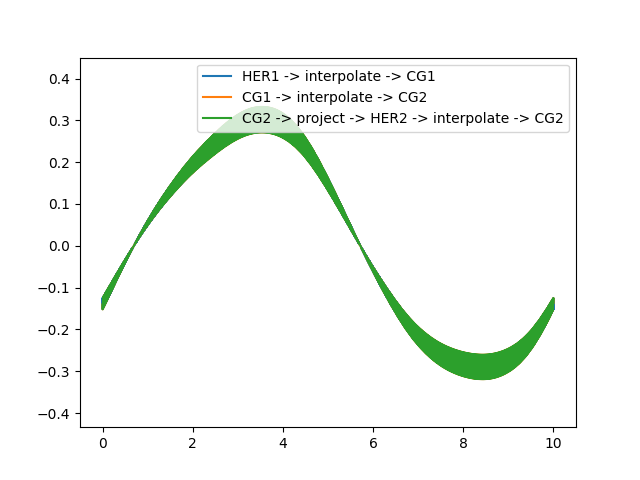

In [6]:
%matplotlib widget

func_cg2_projected = Function(cg2)
func_cg2_projected.interpolate(func_her2)

fig, axes = plt.subplots()
plot(func_cg1, axes=axes, label="HER1 -> interpolate -> CG1")
plot(func_cg2, axes=axes, label="CG1 -> interpolate -> CG2")
plot(func_cg2_projected, axes=axes, label="CG2 -> project -> HER2 -> interpolate -> CG2")
axes.legend()

In [22]:
index = 20
func_her1 = Function(her1, val=samples[index, 0, :].cpu().numpy())
func_cg2 = Function(cg2)
func_cg2.project(func_her1)

NotImplementedError: 
Sorry, only implemented for affine maps for now. To do non-affine, we'd need to
import much more of the assembly engine of UFL/TSFC/etc to do the assembly on
each supermesh cell.


In [51]:
samples1 = torch.load("data/KS/samples/N4096_HER_nu0029_T01_samples1200.pt").unsqueeze(2).to(device=device)
samples2 = torch.load("data/KS/samples/N512_HER_nu0029_T01_samples1200.pt").unsqueeze(2).to(device=device)

with CheckpointFile(f"/home/clustor2/ma/n/np923/fem_neural_operator/playground/data/KS/meshes/N4096.h5", "r") as f:
    mesh1 = f.load_mesh()

with CheckpointFile(f"/home/clustor2/ma/n/np923/fem_neural_operator/playground/data/KS/meshes/N512.h5", "r") as f:
    mesh2 = f.load_mesh()

In [54]:
her1 = FunctionSpace(mesh1, "HER", 3)
her2 = FunctionSpace(mesh2, "HER", 3) 
cg1 = FunctionSpace(mesh1, "CG", 1)
cg2 = FunctionSpace(mesh2, "CG", 1)

func_her1 = Function(her1, val=samples1[index, 1, :].cpu().numpy())
func_her2 = Function(her2, val=samples2[index, 1, :].cpu().numpy())
func_cg2 = Function(cg2)
func_cg1 = Function(cg1)

func_cg1.interpolate(func_her1)
func_cg2.interpolate(func_her2)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f0ba3caaf50>, FiniteElement('Lagrange', interval, 1), name=None), Mesh(VectorElement(FiniteElement('Discontinuous Lagrange', interval, 1, variant='equispaced'), dim=1, variant='equispaced'), 160)), 300)

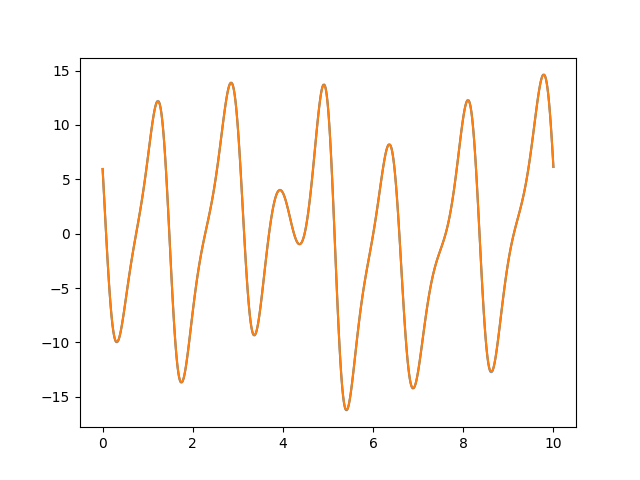

In [55]:
fig, axes = plt.subplots()

plot(func_cg1, axes=axes, label="N4096")
plot(func_cg2, axes=axes, label="N512")

In [3]:
from firedrake import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from classes import *
from classes.Dataset import Dataset
device = torch.device("cuda:3") if torch.cuda.is_available() else torch.device("cpu")


/tmp/ipykernel_360187/2108742934.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainset = Dataset(torch.tensor(samples[:model.train_samples]), torch.tensor(grid))
/tmp/ipykernel_360187/2108742934.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))


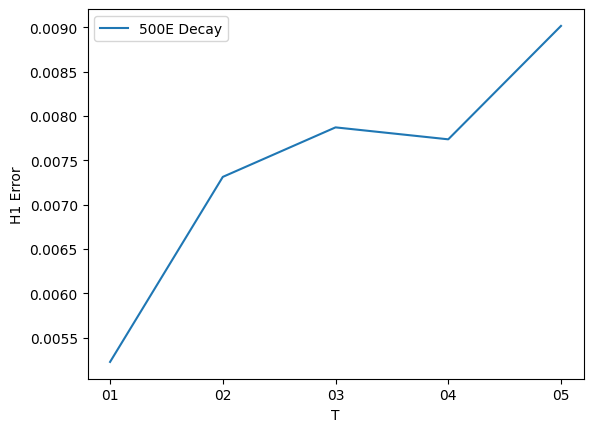

[array(0.00522725, dtype=float32), array(0.007314, dtype=float32), array(0.00787238, dtype=float32), array(0.00773769, dtype=float32), array(0.00901654, dtype=float32)]


In [7]:
N=4096

T_domain = ["01", "02", "03", "04", "05"]
epoches_losses = []
for T in T_domain:
    model = KSModel.load(f"../../data/KS/models/fourier/N{N}/T{T}/D64_M16_samples1000_epoch500.pt", N, T, device)
    data_path = f"../../data/KS/samples/N{N}_HER_nu0029_T{T}_samples1200.pt"
    
    samples = torch.load(data_path).unsqueeze(2).to(device=device, dtype=torch.float32)
    grid = torch.linspace(0, model.L, model.dof_count, device=device)
    trainset = Dataset(torch.tensor(samples[:model.train_samples]), torch.tensor(grid))
    testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))
    
    mean_rel_l2_loss = lambda x, y: torch.mean(torch.norm(x - y, 2, dim=-1)/torch.norm(y, 2, dim=-1))
    
    optimizer = torch.optim.Adam(model.network.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.5)
    
    network_trainer = NeuralNetworkTrainer(
        model,
        trainset,
        testset,
        mean_rel_l2_loss,
        optimizer,
        scheduler,
        max_epoch=500
    )
    
    epoches_losses.append(network_trainer.test_epoch().detach().cpu().numpy())
        

plt.plot(T_domain, epoches_losses, label="500E Decay")
plt.legend()
plt.xlabel("T")
plt.ylabel("H1 Error")
plt.show()
print(epoches_losses)

In [4]:
N=2048

T_domain = ["01", "02", "03", "04", "05"]
epoches_losses = [[], []]
for i, epoches in enumerate([500, 600]):
    for T in T_domain:
        model = KSModel.load(f"data/KS/models/fourier/N2048/T{T}/D20_M8_samples1000_epoch{epoches}.pt",2048, T , device)
        data_path = f"data/KS/samples/N{N}_HER_nu0029_T{T}_samples1200.pt"
        
        samples = torch.load(data_path).unsqueeze(2).to(device=device, dtype=torch.float32)
        grid = torch.linspace(0, model.L, model.dof_count, device=device)
        trainset = Dataset(torch.tensor(samples[:model.train_samples]), torch.tensor(grid))
        testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))
        
        mse_loss = nn.MSELoss(reduction="sum")
        loss = lambda x, y: mse_loss(x, y) / (N * len(x))  # Sum of differences, times step size, divide by batch size
        
        optimizer = torch.optim.Adam(model.network.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.5)
        
        network_trainer = NeuralNetworkTrainer(
            model,
            trainset,
            testset,
            loss,
            optimizer,
            scheduler,
            max_epoch=500
        )
        
        epoches_losses[i].append(network_trainer.test_epoch().detach().cpu().numpy())
        

plt.plot(T_domain, epoches_losses[0], label="500E Decay")
plt.plot(T_domain, epoches_losses[1], label="600E Cyclic")
plt.legend()
plt.xlabel("T")
plt.ylabel("H1 Error")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/KS/models/fourier/N2048/T01/D20_M8_samples1000_epoch500.pt'

In [12]:
device = torch.device("cuda:3") if torch.cuda.is_available() else torch.device("cpu")

T_domain = ["01", "02", "03", "04", "05"]
N_domain = [64, 128, 512, 1024, 2048, 4096]
N_losses = [[], [], [], [], [], []]
for i, N in enumerate(N_domain):
    for T in T_domain:
        model = KSModel.load(f"../../data/KS/models/fourier/N{N}/T{T}/D64_M16_samples1000_epoch500.pt", N, T, device)
        data_path = f"../../data/KS/samples/N{N}_HER_nu0029_T{T}_samples1200.pt"
        
        samples = torch.load(data_path).unsqueeze(2).to(device=device, dtype=torch.float32)
        grid = torch.linspace(0, model.L, model.dof_count, device=device)
        trainset = Dataset(torch.tensor(samples[:model.train_samples]), torch.tensor(grid))
        testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))
        
        mean_rel_l2_loss = lambda x, y: torch.mean(torch.norm(x - y, 2, dim=-1)/torch.norm(y, 2, dim=-1))
        loss = lambda x, y: mse_loss(x, y) / (N * len(x))  # Sum of differences, times step size, divide by batch size
        
        optimizer = torch.optim.Adam(model.network.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.5)
        
        network_trainer = NeuralNetworkTrainer(
            model,
            trainset,
            testset,
            mean_rel_l2_loss,
            optimizer,
            scheduler,
            max_epoch=500
        )
        
        N_losses[i].append(network_trainer.test_epoch().detach().cpu().numpy())
        



/tmp/ipykernel_360187/3555540949.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainset = Dataset(torch.tensor(samples[:model.train_samples]), torch.tensor(grid))
/tmp/ipykernel_360187/3555540949.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))


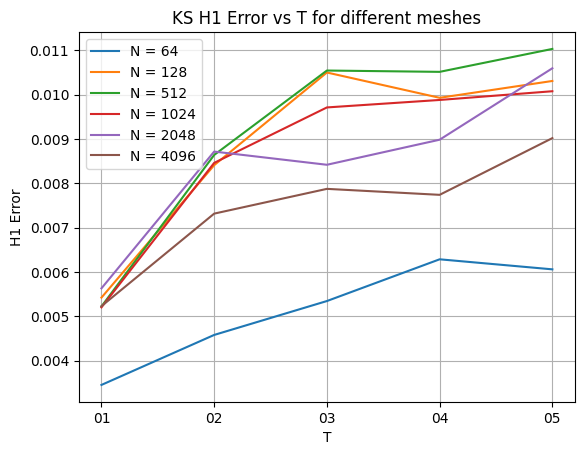

In [13]:
for i, losses in enumerate(N_losses):
    plt.plot(T_domain, losses, label=f"N = {N_domain[i]}")
    
plt.legend()
plt.xlabel("T")
plt.ylabel("H1 Error")
plt.grid()
plt.title("KS H1 Error vs T for different meshes")
plt.show()

In [46]:
N = 4096
L = 10.
T = 0.5
nu = 0.029
dt = 0.01
samples = 600


with CheckpointFile(f"/home/clustor2/ma/n/np923/fem_neural_operator/fem_neural_operator/data/KS/meshes/N{N}.h5", "r") as f:
    mesh = f.load_mesh()
    
her = FunctionSpace(mesh, "HER", 3) 
fs_out = FunctionSpace(mesh, "CG", 1)

x = SpatialCoordinate(her)[0]

In [47]:

sin_her = Function(her).project(Constant(1))
sin_her.dat.data

array([ 1.00000000e+00, -2.19748446e-15,  1.00000000e+00, ...,
       -6.39160420e-15,  1.00000000e+00, -4.28372051e-15])

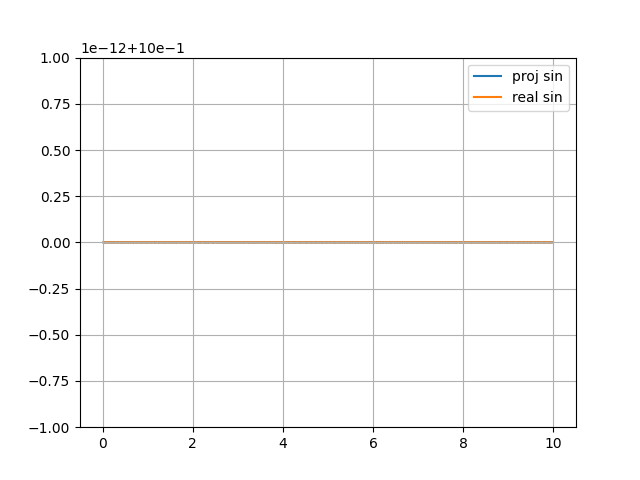

In [48]:
%matplotlib widget

fig, axes = plt.subplots()

plot(Function(fs_out).interpolate(sin_her), label="proj sin", axes=axes)
plot(Function(fs_out).interpolate(Constant(1)), label="real sin", axes=axes)

axes.grid()
axes.legend()

In [14]:
functions = torch.zeros((2 * self.M + 1, fs.dof_count), dtype=torch.float64)  # Zero mode and cos, sin for each mode

for i in range(self.M + 1):
    if i == 0:
        self.functions[i, :] = torch.tensor(fd.Function(function_space).interpolate(1).dat.data)
        continue

    self.functions[2 * i -1, :] = torch.tensor(fd.Function(function_space).interpolate(fd.sin(i * 2 * fd.pi * x)).dat.data)
    self.functions[2 * i, :] = torch.tensor(fd.Function(function_space).interpolate(fd.cos(i * 2 * fd.pi * x)).dat.data)


NameError: name 'self' is not defined

In [7]:
device = torch.device("cuda:3") if torch.cuda.is_available() else torch.device("cpu")

model_filename = "/home/clustor2/ma/n/np923/fem_neural_operator/fem_neural_operator/data/KS/models/fourier/N64/T01/D20_M8_samples1000_epoch500.pt"
model = KSModel.load(model_filename, 64, "01", device)

In [15]:
with CheckpointFile(f"/home/clustor2/ma/n/np923/fem_neural_operator/fem_neural_operator/data/KS/meshes/N{64}.h5", "r") as f:
    mesh = f.load_mesh()
    
her = FunctionSpace(mesh, "HER", 3) 
fs_out = FunctionSpace(mesh, "CG", 3)

func = Function(her, val=model.network.projection.functions[3, :].detach().cpu().numpy())

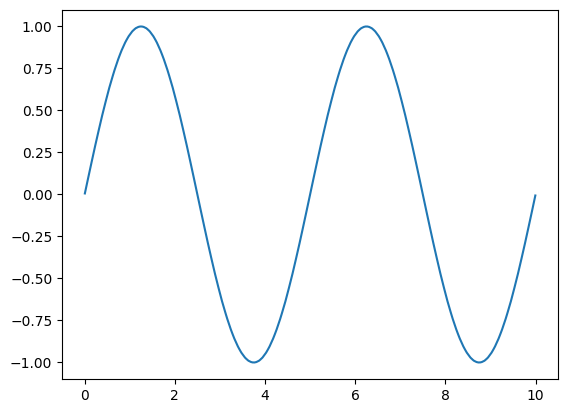

In [16]:
plot(Function(fs_out).project(func))

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

T_domain = ["01", "02", "03", "04", "05"]
N_domain = [64, 128, 512, 1024, 2048, 4096]
N_losses = [[], [], [], [], [], []]
for i, N in enumerate(N_domain):
    for T in T_domain:
        model = KSModel.load(f"../../data/KS/models/fourier/N{N}/T{T}/D64_M16_samples1000_epoch500.pt", N, T, device)
        data_path = f"../../data/KS/samples/N{N}_HER_nu0029_T{T}_samples1200.pt"
        
        samples = torch.load(data_path).unsqueeze(2).to(device=device, dtype=torch.float32)
        grid = torch.linspace(0, model.L, model.dof_count, device=device)
        trainset = Dataset(torch.tensor(samples[:model.train_samples]), torch.tensor(grid))
        testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))
        
        mean_rel_l2_loss = lambda x, y: torch.mean(torch.norm(x - y, 2, dim=-1)/torch.norm(y, 2, dim=-1))
        loss = lambda x, y: mse_loss(x, y) / (N * len(x))  # Sum of differences, times step size, divide by batch size
        
        optimizer = torch.optim.Adam(model.network.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.5)
        
        network_trainer = NeuralNetworkTrainer(
            model,
            trainset,
            testset,
            mean_rel_l2_loss,
            optimizer,
            scheduler,
            max_epoch=500
        )
        
        N_losses[i].append(network_trainer.test_epoch().detach().cpu().numpy())
        



In [7]:
from classes import KSModel, Dataset
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [83]:
# Check this out, the error is extremely small for:
# N=64, T=08, i=138, predict=5.331821739534636e-06, truth=-4.889443647457229e-08
# N=128, T=15, i=33, predict=-4.561152311027174e-06, truth=2.5902409178449334e-07
# N=512, T=01, i=160, predict=2.532033042158633e-07, truth=5.6315907747195814e-08
# N=2048, T=07, i=134, predict=-3.0340742026935653e-07, truth=-4.09238327161094e-08


T_domain = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15"]
N_domain = [64, 128, 512, 1024, 2048]

prediction_integrals = []
for N in N_domain:
    with CheckpointFile(f"../../data/KS/meshes/N{N}.h5", "r") as f:
        mesh = f.load_mesh()
        
    her = FunctionSpace(mesh, "HER", 3) 
    
    for T in T_domain:
        model = KSModel.load(f"../../data/KS/models/fourier/N{N}/T{T}/D64_M16_samples1000_epoch500.pt", N, T, device)
        data_path = f"../../data/KS/samples/N{N}_HER_nu0029_T{T}_samples1200.pt"
        
        samples = torch.load(data_path).unsqueeze(2).to(device=device, dtype=torch.float32)
        grid = torch.linspace(0, model.L, model.dof_count, device=device)
        testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))
        
        with torch.no_grad():
            predictions = model.network(testset.inputs).detach().cpu().numpy()

        # prediction_integrals = []
        for i in range(200):
            f_predict = Function(her, val=predictions[i, 0, :])
            f_truth = Function(her, val=testset.targets[i, 0, :].detach().cpu().numpy())
            integral_predict = assemble(f_predict * dx)
            integral_truth = assemble(f_truth * dx)

            prediction_integrals.append(integral_predict)
            
            # if (abs(integral_predict) < 10E-06):            
            #     print(f"N={N}, T={T}, i={i}, predict={integral_predict}, truth={integral_truth}")
        
            # prediction_integrals.append(integral_predict)

/tmp/ipykernel_37277/1231045529.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))
/tmp/ipykernel_37277/1231045529.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))
/tmp/ipykernel_37277/1231045529.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))
/tmp/ipykernel_37277/1231045529.py:24: U

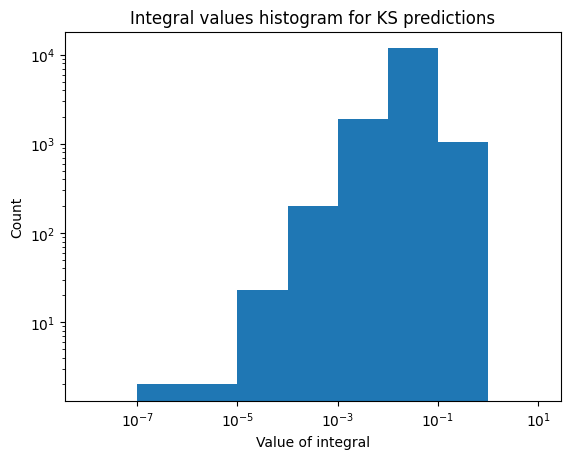

In [97]:

plt.hist(np.abs(prediction_integrals), bins=[10**i for i in [-8, -7, -6, -5, -4, -3, -2, -1 ,0, 1]])
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Count")
plt.xlabel("Value of integral")
plt.title("Integral values histogram for KS predictions")
plt.savefig("KS integral values histogram")

In [101]:
compositions = 10
i = 160

integrals = []
with torch.no_grad():
    for _ in range(compositions):
        testset.inputs[:, 0, :] = model.network(testset.inputs)[:, 0, :]
        # for i in range(200):
        f_predict = Function(her, val=testset.inputs[i, 0, :].detach().cpu().numpy())
        integrals.append(abs(assemble(f_predict * dx)))

        # integral_means.append(np.mean(np.abs(integrals)))


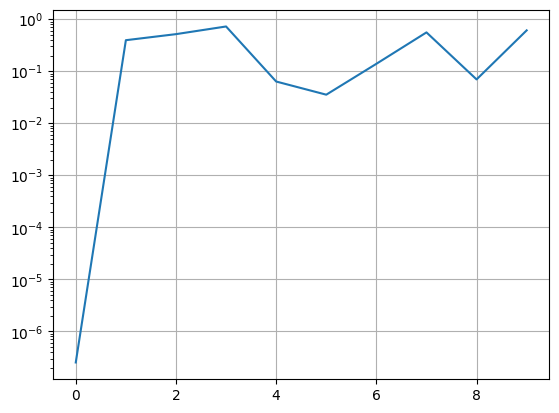

In [102]:
plt.plot(list(range(compositions)), integrals)
plt.grid()
plt.yscale("log")

In [103]:
integrals

[2.532033042158633e-07,
 0.39593364897883787,
 0.5174973141402034,
 0.7266158069251121,
 0.06359759077894027,
 0.03552072041201016,
 0.1392467113328075,
 0.5592521181097257,
 0.06978491757763576,
 0.6118334541679356]

# H1 Norm discrepancy 

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

N = 1024
L = 10
h = L/N

mesh = PeriodicIntervalMesh(ncells=N, length=L)
x = SpatialCoordinate(mesh)[0]
her = FunctionSpace(mesh, "HER", 3) 

sin_func = Function(her)
sin_func.project(sin(2 * pi *x /L))

cos_func = Function(her)
cos_func.project(cos(2 * pi *x /L))

# diff_func = Function(her, val=sin_func.dat.data - cos_func.dat.data)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x787d66f675e0>, FiniteElement('Hermite', interval, 3), name=None), Mesh(VectorElement(FiniteElement('Discontinuous Lagrange', interval, 1, variant='equispaced'), dim=1, variant='equispaced'), 27)), 36)

In [11]:
fd_L2_norm = norm(sin_func, "L2")
fd_H1_norm = norm(sin_func, "H1")
coeff_norm = np.sqrt(h * np.sum(sin_func.dat.data ** 2))

In [12]:
print(f"Firedrake L2: {fd_L2_norm}")
print(f"Firedrake H1: {fd_H1_norm}")
print(f"Riemann sum (H1): {coeff_norm}")

Firedrake L2: 2.236067977499789
Firedrake H1: 2.640818221729368
Riemann sum (H1): 2.236110070587828


In [13]:
# sin_func.dat.data[0::4] gives the left point-evaluation
# sin_func.dat.data[1::4] gives the left derivative point-evaluation
# sin_func.dat.data[2::4] gives the right point-evaluation
# sin_func.dat.data[3::4] gives the right derivative point-evaluation

pullback_ratio = 1/h
coeff_norm = h ** 0.5 * np.sqrt(np.sum(sin_func.dat.data[0::4] ** 2) + \
             np.sum((pullback_ratio * sin_func.dat.data[1::4]) ** 2) + \
             np.sum(sin_func.dat.data[2::4] ** 2) + \
             np.sum((pullback_ratio*sin_func.dat.data[3::4]) ** 2))

coeff_norm - fd_H1_norm

1.6908696665041134e-11

In [44]:
from classes import KSModel, Dataset

N = 512
L = 10
h = L/N

model = KSModel.load(f"../../data/KS/models/fourier/N{N}/T01/D64_M16_samples1000_epoch500.pt", N, "01", device)

data_path = f"../../data/KS/samples/N{N}_HER_nu0029_T01_samples1200.pt"
samples = torch.load(data_path).unsqueeze(2).to(device=device, dtype=torch.float32)

grid = torch.linspace(0, model.L, model.dof_count, device=device)
testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))

with CheckpointFile(f"../../data/KS/meshes/N{N}.h5", "r") as f:
    mesh = f.load_mesh()

her = FunctionSpace(mesh, "HER", 3)

/tmp/ipykernel_19056/3597045910.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))


In [15]:
with torch.no_grad():
    predictions = model.network(testset.inputs)

In [32]:
i = 66
coeffs_predict = predictions[i, 0, :].to(dtype=torch.float64, device="cpu").numpy()
coeffs_target = testset.targets[i, 0, :].to(dtype=torch.float64, device="cpu").numpy()
coeffs = coeffs_target - coeffs_predict

fd_errornorm = errornorm(Function(her, val=coeffs_predict), Function(her, val=coeffs_target), "H1")
fd_norm = norm(Function(her, val=coeffs_predict), "H1")


pullback_ratio = 1/h

coeff_errornorm = h ** 0.5 * np.sqrt(np.sum(coeffs[0::4] ** 2) + \
             np.sum((pullback_ratio * coeffs[1::4]) ** 2) + \
             np.sum(coeffs[2::4] ** 2) + \
             np.sum((pullback_ratio*coeffs[3::4]) ** 2))

coeff_norm = h ** 0.5 * np.sqrt(np.sum(coeffs_predict[0::4] ** 2) + \
             np.sum((pullback_ratio * coeffs_predict[1::4]) ** 2) + \
             np.sum(coeffs_predict[2::4] ** 2) + \
             np.sum((pullback_ratio * coeffs_predict[3::4]) ** 2))


print(f"Firedrake H1 norm: {fd_norm:.5}, Coefficient H1 norm: {coeff_norm:.5}")
print()
print(f"Firedrake H1 errornorm: {fd_errornorm:.5}, Coefficient H1 errornorm: {coeff_errornorm:.5}")

Firedrake H1 norm: 119.41, Coefficient H1 norm: 118.97

Firedrake H1 errornorm: 5.5438, Coefficient H1 errornorm: 2.6413


In [33]:
norms = []
for i in range(len(testset)):
    func_in = Function(her, val = testset.targets[i, 0, :].cpu().numpy())
    predict = Function(her, val = predictions[i, 0, :].cpu().numpy())
    norms.append(errornorm(futnc_in, predict, "H1")/norm(func_in, "H1"))

np.mean(norms)

0.056031836394246734

In [34]:
h = 10/N

testset.targets[:, 0, 1::4] *= 1/h
testset.targets[:, 0, 3::4] *= 1/h

predictions[:, 0, 1::4] *= 1/h
predictions[:, 0, 3::4] *= 1/h


# h**0.5 * np.linalg.norm(coeffs)
# np.sqrt(h * np.sum(coeffs[0::4] ** 2) + \
#              h * np.sum((1/h * coeffs[1::4]) ** 2) + \
#              h * np.sum(coeffs[2::4] ** 2) + \
#              h * np.sum((1/h*coeffs[3::4]) ** 2))

In [35]:
mean_rel_l2_loss = lambda x, y: torch.mean(torch.norm(x - y, 2, dim=-1) / torch.norm(y, 2, dim=-1))
mean_rel_l2_loss(predictions, testset.targets)

tensor(0.0252, device='cuda:0')

In [201]:
np.sqrt(h * np.sum(sin_func.dat.data **2) + h * np.sum(sin_func.dx().dat.data **2))

31.780646728982106

In [202]:
dfdx = Function(her)
dfdx.project(sin_func.dx(0))
np.sqrt(h * np.sum(sin_func.dat.data **2) + h * np.sum(dfdx.dat.data **2))

26.540019568027038

In [45]:
for i, val in enumerate(Function(her).project(Constant(1)).dat.data):
    if val < 10**(-12) and i % 2 != 1:
        print("ahahahahha")